In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#### Read the Data
###### Link: https://archive.ics.uci.edu/static/public/45/heart+disease.zip
filename = "processed.cleveland.data"
feature_dictionary = {
    "age": "Age of a candidate",
    "sex": "Sex of a candidate",
    "cp": "chest pain",
    "restbp": "resting blood pressure (in mm Hg)",
    "chol": "serum cholestrol in (mg/dl)",
    "fbs": "fasting blood sugar",
    "restecg": "resting electrocardographic results",
    "thalach": "maximum heart rate achieved",
    "exang": "exercise induced agnia",
    "oldpeak": "ST depression induced by exercise relative to rest",
    "slope": "the slope of the peak exercise ST segment",
    "ca": "number of major vessels(0-3) colored by fluoroscopy",
    "thal": "this is short of thallium heart scan",
    "hd": "diagnosis of heart disease, the predicted attribute"
}
headers = list(feature_dictionary.keys())
df = pd.read_csv(
    filename,
    header=None
)

df.columns = headers
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


##### EDA

In [3]:
# Number of rows and column of data, and check for duplicates in the data
df.shape, df.drop_duplicates().shape

((303, 14), (303, 14))

In [4]:
# Check for data types of each columns
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [5]:
# Check for Nulls in each columns
df.isna().sum()

age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
hd         0
dtype: int64

In [6]:
# Check for empty string in any columns
df.eq("").sum()

age        0
sex        0
cp         0
restbp     0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
hd         0
dtype: int64

In [7]:
# Since the data type of "thal" and "ca" is object
# object: (Generally when we have mixed datatypes present in a column, object datatype gets assigned to it)

# Let's check unique values in "thal" and "ca"
df["thal"].value_counts(normalize=True), df["ca"].value_counts(normalize=True)

(thal
 3.0    0.547855
 7.0    0.386139
 6.0    0.059406
 ?      0.006601
 Name: proportion, dtype: float64,
 ca
 0.0    0.580858
 1.0    0.214521
 2.0    0.125413
 3.0    0.066007
 ?      0.013201
 Name: proportion, dtype: float64)

#### Imputing the missing values

In [8]:
# Now that, we have missing values in two columns namely "ca" and "thal"
# We need use a suitable imputer for them

# Lets what percent of data is missing
df.value_counts(["ca", "thal"], normalize=True).reset_index().query("(ca == '?') | (thal == '?')")

# We can see, there is roughly 2% of data has missing values
# There is no harm in dropping these datasets

,ca,thal,proportion
11,0.0,?,0.006601
13,?,3.0,0.006601
14,?,7.0,0.006601


In [9]:
# Filter the data after removing missing values from "ca" and "thal"
df_no_missing = df.query(
    "(ca != '?') & (thal != '?')"
).reset_index(drop=True)
df_no_missing.shape

(297, 14)

#### Split the data to make classification tree

In [10]:
# Check the dtypes of data
df_no_missing.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

In [11]:
# Get the columns for X and y
X = df_no_missing.select_dtypes(exclude='int') # Because Integer datatype is used for Y variable
y = df_no_missing.select_dtypes(include='int')

In [12]:
X.shape, y.shape

((297, 13), (297, 1))

#### Encoding of categorical data

In [13]:
# On analyzing a categorical feature "cp", we oberve it has 4 values
# 1: typical angina
# 2: atypical angina
# 3: Non anginal pain
# 4: asymptomatic

# If we treat this categories as it is, the model is going to assume
# Category 4 is similar to Category 3 than to Category 1 and 2
X['cp'].value_counts()

cp
4.0    142
3.0     83
2.0     49
1.0     23
Name: count, dtype: int64

In [14]:
# We will perform one hot encoding on the categorical dataframes
cols_to_encode = [
    "cp", "restecg", "slope", "thal"
]
X_encoded = pd.get_dummies(
    X, columns=cols_to_encode
)
X_encoded.head()


,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


In [15]:
# Process y such that it contains only two categories 0 and 1
print(f"Unique values present in y: {y["hd"].unique()}")

y.loc[y["hd"] > 0, ['hd']] = 1

print(f"Unique values present in y after processing: {y["hd"].unique()}")
y.value_counts()

Unique values present in y: [0 2 1 3 4]
Unique values present in y after processing: [0 1]


hd
0     160
1     137
Name: count, dtype: int64

#### Build a premliminary Classification Tree

In [16]:
# Split the data into Test and Train
seed_for_random_numbers = 42
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, random_state=seed_for_random_numbers
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((222, 22), (222, 1), (75, 22), (75, 1))

In [ ]:
# Decision Tree Classifier Parameters description
# Link: An empirical study of hyper-parameter on Decision Tree
# https://arxiv.org/abs/1812.02207
""" 
1. criterion: default=gini
The function to measure quality of split
   a: Gini Impurity (gini): 1 - SUMMATION(pi(x)^2), where pi(x) is probability of event or class
   b. log_loss (log_loss): [TODO]: 
   c. Entropy (entropy): -SUMMATION(pi(x) * log2(pi(x))), where pi(x) is probability of even or class

2. splitter: default=best
The strategy used to split at each node.
    a. Best (best): It is used to choose the best split. It will go through all possible threshold and choose the one with best criterion.
    b. Random (random): It is used to choose the best random split. It will randomly choose the threshold and split the data.

3. max_depth: default=None
The maximum depth of the tree.
If None, nodes are expanded untill all the leaves are pure or until all leaves contain less than "min_samples_split_sample"
If the depth of tree is increased then it is prone to overfitting. 
If the depth of the tree is decreased then it is prone to underfitting.

4. min_samples_split: default=2
The minimum numbers of samples required to split an internal nodes.
It can take two values:
    a. int: It considers min_samples_split as the minimum numbers.
    b. float: mini_samples_split is CEIL(min_samples_split * n_samples) are the minimum number of samples for each split.

If this value is too high then it will lead to underfitting.
If this value is too low then model can overfit on data.
Typically, its value should range in between 1 and 40.

5. min_samples_leaf: default=0
The minimum number of samples required to be at a leaf node. 
A split at any depth at any node will only be considered if it leaves at least "min_samples_leaf" training samples 
in each of the left and right branch.

It can take two values:
    a. int: It considers min_samples_split as the minimum numbers.
    b. float: mini_samples_split is CEIL(min_samples_split * n_samples) are the minimum number of samples for each split.

This parameter is also used to control for overfit of Model.
Typically, its value should range in between 1 and 20, except for class imbalance problem.

6. min_weight_fraction_leaf: default=0.0
The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
Samples have equal weight when samples_weight is not provided.

[TODO]: Learn more about it as it can help with the cases of class IMBALANCE.

7. max_features: default=None
The number of features to consider when looking for the best split:

It can take multiple values:
    a. int: Then consider max_feature at each split.
    b. float: max_feature = max(1, int(max_features * n_features_in_)) feature are considered at each split
    c. sqrt: then max_features = sqrt(n_features)
    d. log2: max_features = log2(n_features)
    e. If None: then max_features=None

The use of max_features is to limit overfitting.
By choosing the limit reduced number of features we can increase the stability of the tree and reduce variance and overfitting.

8. random_state: default=None
It controls the randomness of the estimator. The features are always randomly permuted at each split, even if "splitter" is set to best.
When max_features < n_features, the algorithm will select max_features at random at each split before finding the best split among them.
To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer.

9. min_impurity_decrease: default=None
A node will be split if this split induces a decrease of the impurity greater than equal to this value.
The weighted impurity decrease equation is following:
    N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)
    N: Total number of samples 
    N_t: Number of samples at current node
    N_t_L: Number of samples in the left child
    N_t_R: Number of samples in the right child

    N, N_t, N_t_L, N_t_R all refer to weighted sum, if sample_weight is passed.

10. max_leaf_nodes: default=None
Grow a tree with 5 nodes in the best-fit fashion.
Best nodes are defined as relative reduction in impurity. 
If None, then unlimited number of leaf nodes.

11. class_weight: default=None

If None, all classes are supposed to have weight one. 


It can takes values:
    dict: Weights associated with classes in the form {class_label: weight}.
    List of Dict: For multi-output problems, a list of dicts can be provided, in the same order as the columns of y.
    [
        {0: 1, 1: 0.5},
        {0: 1, 1: 1},
        {0: 0.5, 1: 1},
        {0: 0.5, 1: 0.5}
    ]
    balanced: It uses the value of y to automatically adjust weights inversely proportional to the class frequencies in the input data as:
        n_samples / (n_classes * np.bincount(y))

12: ccp_alpha: default=None
Complexity parameter used for Minimal cost-complexity Pruning.
The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

13. monotonic_cst: default=None
Indicates the monotonicity constraints to enforce on each feature.
    
It can take following values for each feature:
    1: monotonic increase
    0: non contsraint
    -1: monotonic decrease

It basically sort the feature in ascending or descending order.

"""


In [87]:
# Parameters for DecisionTreeClassifier
clf_dt_params = {
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 2,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': [1] * X_train.shape[1],
 'random_state': seed_for_random_numbers,
 'splitter': 'best'
 }

# Create a base Decision Tree
clf_dt = DecisionTreeClassifier(**clf_dt_params)
clf_dt = clf_dt.fit(X_train, y_train)

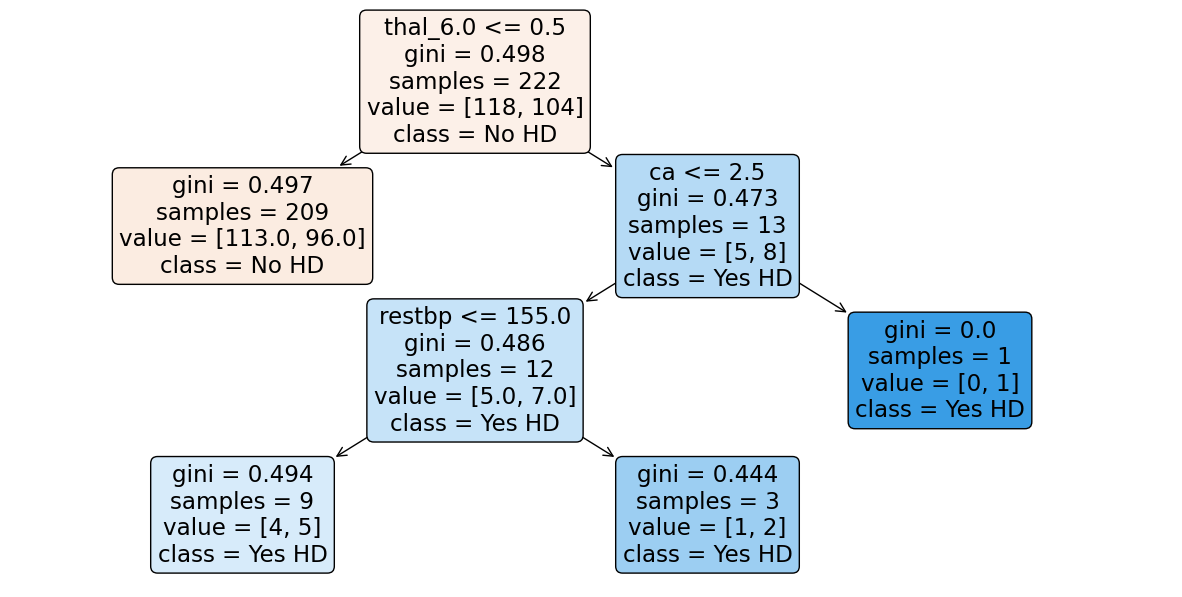

In [88]:
# Plot the Decision Tree
plt.figure(figsize=(15, 7.5))
plot_tree(
    clf_dt,
    filled=True,
    rounded=True,
    class_names=["No HD", "Yes HD"],
    feature_names=X_encoded.columns
)
plt.show()

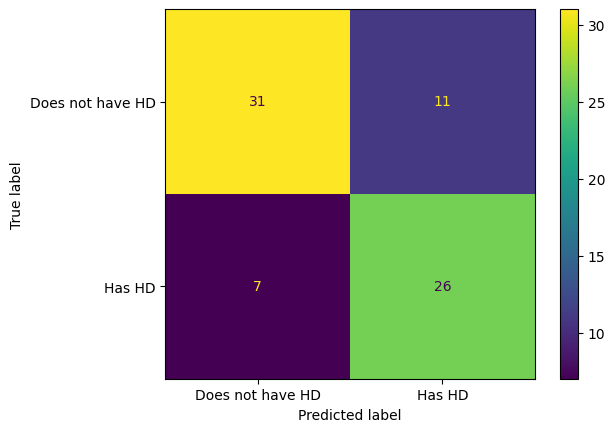

In [19]:
# Measure the performance of this tree on testing datasets
y_test_pred = clf_dt.predict(X_test)
test_confusion_matrix = confusion_matrix(
    y_test, y_test_pred, labels=clf_dt.classes_
)

ConfusionMatrixDisplay(
    test_confusion_matrix,
    display_labels=["Does not have HD", "Has HD"]
).plot()